In [1]:
%cd ../..

/home/eli/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from combinators.inference import importance, mcmc
from combinators.kernel import kernel, mh
import combinators.model as model
from combinators import utils

In [3]:
import examples.ais.ais_1d_gaussians as ais_example
import examples.ais.image_density as image_density

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
from scipy.misc import imread
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

img_ary = imread('examples/ais/probtorch-logo-bw.png', mode='L').astype(float)
img_ary = gaussian_filter(img_ary, sigma=1)

In [6]:
ANNEALING_STEPS = 50
BATCH_SHAPE = (1,)

In [7]:
T = 10000
annealed_points = torch.zeros((0, 2))
log_weights = torch.zeros((0))
for t in range(T):
    proposal = image_density.AnnealingProposal(image_density.ImageProposal(batch_shape=BATCH_SHAPE), ANNEALING_STEPS)
    target = model.Compose(image_density.ProbtorchLogoDensity(batch_shape=BATCH_SHAPE), proposal)
    ais = ais_example.annealed_importance_MH(target, kernel.LinScaledGaussianKernel('ProbtorchLogoDensity.ImageProposal/ImageProposal', 'ImageProposal', scale=100.0, n_steps=ANNEALING_STEPS), moves=ANNEALING_STEPS)
    annealed_batch, trace, log_weight = ais(data={'image': torch.FloatTensor(img_ary)})
    annealed_points = torch.cat((annealed_points, annealed_batch))
    log_weights = torch.cat((log_weights, log_weight))

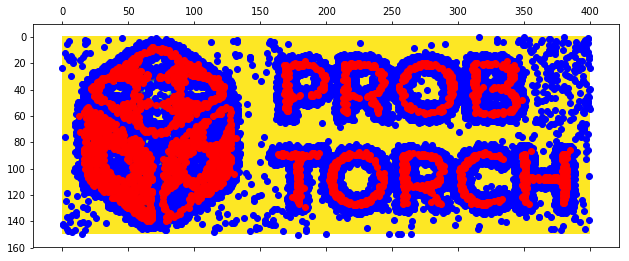

In [8]:
weights = log_weights.exp()
plt.matshow(img_ary)
plt.scatter(annealed_points[(weights <= .9).nonzero(), 0], annealed_points[(weights <= .9).nonzero(), 1], c='b')
plt.scatter(annealed_points[(weights > .9).nonzero(), 0], annealed_points[(weights > .9).nonzero(), 1], c='r')
plt.savefig('probtorch_logo_ais.pdf')

In [9]:
a = torch.tensor([[278.9529, 140.2809]])
torch.stack((a, a), dim=1)

tensor([[[278.9529, 140.2809],
         [278.9529, 140.2809]]])

In [23]:
plot_log_weights = log_weights - log_weights.max(dim=0)[0]
plot_weights = plot_log_weights.exp()

In [24]:
rgba_colors = torch.zeros((annealed_points.shape[0], 4))
rgba_colors[:, 0] = 1.0
rgba_colors[:, 3] = plot_weights

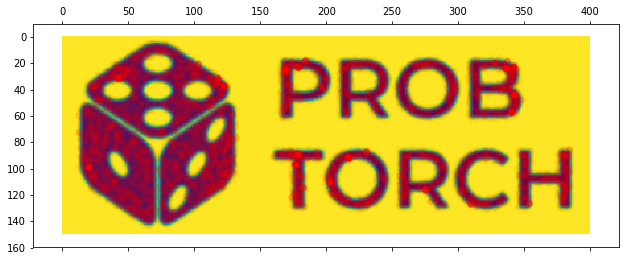

In [25]:
plt.matshow(img_ary)
plt.scatter(annealed_points[:, 0], annealed_points[:, 1], c=rgba_colors)
plt.savefig('probtorch_logo_ais_alphas.pdf')

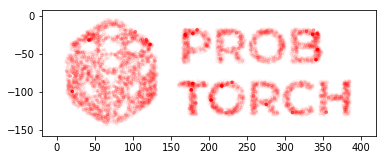

In [44]:
ax = plt.axes()
ax.set_aspect('equal')
axis = ax.scatter(annealed_points[:, 0], -annealed_points[:, 1], c=rgba_colors, s=7)
plt.savefig('probtorch_logo_ais_noimg.pdf')